# Variant effect prediction

In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import load_table
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_curve(V, results, curve, title, pos_label="Pathogenic", pos_prop=None, save_path=None):
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label==pos_label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,

}


def histplot_label(V, save_path=None, **kwargs):
    V["Label"] = V.source + "/\n" + V.label
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="Label",
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [23]:
plot_dir = "../../results/plots/"

In [3]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
}

In [13]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
]

nt_models = [
    #"InstaDeepAI/nucleotide-transformer-500m-human-ref",
    #"InstaDeepAI/nucleotide-transformer-500m-1000g",
    #"InstaDeepAI/nucleotide-transformer-2.5b-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
]

hyenadna_models = [
    #'LongSafari/hyenadna-tiny-1k-seqlen-hf',
    #'LongSafari/hyenadna-small-32k-seqlen-hf',
    #'LongSafari/hyenadna-medium-160k-seqlen-hf',
    #'LongSafari/hyenadna-medium-450k-seqlen-hf',
    'LongSafari/hyenadna-large-1m-seqlen-hf',    
]

model_renaming = { 
    # GPN-MSA
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    
    # NT models
    "InstaDeepAI/nucleotide-transformer-500m-human-ref": "NT-500m-human-ref",
    "InstaDeepAI/nucleotide-transformer-500m-1000g": "NT-500m-1000g",
    "InstaDeepAI/nucleotide-transformer-2.5b-1000g": "NT-2.5b-1000g",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT-2.5b-multi-species",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    #"phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

dataset_models = {
    "ClinVar": core_models + nt_models + hyenadna_models + ["ESM-1b"],

    "COSMIC": core_models + ["ESM-1b"],

    "OMIM": {
        "all": core_models,
        "Promoter": core_models,
        "Enhancer": core_models,
        "5' UTR": core_models,
        "3' UTR": core_models,
        "ncRNA": core_models,
    },
    
    "gnomAD": {
        "all": core_models,
        
        #"missense": core_models,
        "missense": core_models + ["ESM-1b"],
        
        "synonymous": core_models,
        "5_prime_UTR": core_models,
        "3_prime_UTR": core_models,
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        #"intron": core_models,
        "intron": core_models  + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
    },
}
models = gather_unique_values(dataset_models)
models

['multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True',
 'CADD.RawScore',
 'phyloP',
 'phyloP-Zoonomia',
 'phastCons',
 'InstaDeepAI/nucleotide-transformer-2.5b-multi-species',
 'LongSafari/hyenadna-large-1m-seqlen-hf',
 'ESM-1b',
 'SpliceAI']

In [14]:
dataset_path = "songlab/human_variants"
V = load_dataset(dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
V

Repo card metadata block was not found. Setting CardData to empty.


,chrom,pos,ref,alt,label,source,consequence,id,review_status,GENOMIC_MUTATION_ID,...,MAC,GPN-MSA,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT,HyenaDNA,ESM-1b,SpliceAI
0,1,14731,G,A,Rare,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,1.0,-5.210156,-1.201975,-1.056,-1.922,-0.066,NaN,NaN,NaN,NaN
1,1,16487,T,C,Common,gnomAD,"downstream_gene_variant,intron_variant&non_cod...",None,None,None,...,9468.0,-3.700708,-1.555390,-0.506,1.811,-0.692,NaN,NaN,NaN,NaN
2,1,62015,C,G,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,1.0,-3.661296,-0.099682,-1.102,-0.311,-0.007,NaN,NaN,NaN,NaN
3,1,62046,A,T,Rare,gnomAD,"intron_variant&non_coding_transcript_variant,u...",None,None,None,...,1.0,-2.069237,-0.303666,-0.310,-0.249,-0.001,NaN,NaN,NaN,NaN
4,1,64866,T,G,Rare,gnomAD,"downstream_gene_variant,upstream_gene_variant",None,None,None,...,1.0,-1.538166,-0.300370,-0.058,-0.299,-0.001,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9761262,Y,2787426,C,G,Pathogenic,ClinVar,missense_variant,9739,"criteria_provided,_single_submitter",None,...,NaN,-6.517984,-2.215825,-5.679,-5.114,-1.000,0.026627,4.976988e-06,-9.000,-0.00
9761263,Y,2787515,C,A,Pathogenic,ClinVar,missense_variant,492908,no_assertion_criteria_provided,None,...,NaN,-0.703199,-1.614399,0.091,-0.120,-0.000,-2.883606,2.861023e-06,-4.780,-0.01
9761264,Y,2787551,C,T,Pathogenic,ClinVar,missense_variant,9754,no_assertion_criteria_provided,None,...,NaN,-0.416216,-0.541464,-0.675,-0.120,-0.989,0.077271,-2.950430e-06,-4.299,-0.00
9761265,Y,2787678,C,T,Pathogenic,OMIM,Enhancer Mutations,None,None,None,...,NaN,0.090255,-0.274381,0.360,-0.120,-0.001,NaN,NaN,NaN,-0.00


In [7]:
dataset_path = "results/variants_enformer/"
V_enformer = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in core_models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_enformer[model_name] = pd.read_parquet(model_path)["score"].values
V_enformer

,chrom,pos,ref,alt,AC,AN,AF,consequence,MAF,Enformer_l1,Enformer_l2,Enformer_linf,GPN-MSA,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates
0,1,61993,C,T,754,140936,0.005350,"intron_variant&non_coding_transcript_variant,u...",0.005350,-3.689453,-0.080139,-0.012398,-0.825256,-0.293977,0.640,-0.311,-0.003
1,1,64649,A,C,2523,140200,0.017996,"downstream_gene_variant,upstream_gene_variant",0.017996,-1.554688,-0.033447,-0.004086,-2.368659,-0.241779,-0.034,-0.107,-0.001
2,1,108869,G,T,779,150338,0.005182,"downstream_gene_variant,intron_variant&non_cod...",0.005182,-1.117188,-0.024780,-0.003456,-1.367970,-0.141906,-0.028,0.000,-0.001
3,1,109503,G,A,1224,149682,0.008177,"downstream_gene_variant,intron_variant&non_cod...",0.008177,-0.847168,-0.016434,-0.001889,-1.751505,-0.247377,-0.740,1.351,-0.003
4,1,115746,C,T,5936,146996,0.040382,"TF_binding_site_variant,downstream_gene_varian...",0.040382,-3.269531,-0.064819,-0.003838,-0.968180,-0.150182,-0.368,-0.338,-0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780263,22,50795915,G,T,8197,151596,0.054071,"intron_variant&non_coding_transcript_variant,u...",0.054071,-1.449219,-0.033478,-0.007637,0.745547,0.602580,2.806,-0.092,-0.007
5780264,22,50796371,G,A,1414,140624,0.010055,"intron_variant&non_coding_transcript_variant,r...",0.010055,-4.253906,-0.100342,-0.020645,0.369854,0.084790,-0.190,-0.337,-0.019
5780265,22,50796466,C,T,1182,150168,0.007871,"intron_variant&non_coding_transcript_variant,r...",0.007871,-3.597656,-0.088745,-0.026398,1.946085,0.080695,1.113,0.872,-0.004
5780266,22,50797531,T,C,18143,144892,0.125217,"intron_variant&non_coding_transcript_variant,u...",0.125217,-0.929688,-0.023956,-0.006439,-2.318055,-0.515404,-0.181,-0.133,-0.301


In [15]:
models = [model_renaming.get(m, m) for m in models]
models

['GPN-MSA',
 'CADD',
 'phyloP',
 'phyloP-241-mammals',
 'phastCons-100-vertebrates',
 'NT',
 'HyenaDNA',
 'ESM-1b',
 'SpliceAI']

In [16]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [17]:
V_clinvar = V[
    (V.source == "ClinVar") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_clinvar.dropna(subset=dataset_models["ClinVar"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        13117
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

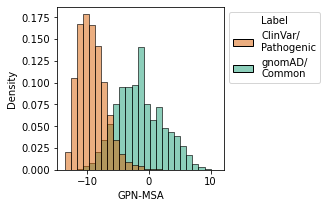

In [13]:
histplot_label(
    V_clinvar,
    hue_order=["ClinVar/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_clinvar.svg",
)

In [18]:
rows = []
for m in dataset_models["ClinVar"]:
    AUROC = roc_auc_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    AUPRC = average_precision_score(V_clinvar.label=="Pathogenic", -V_clinvar[m])
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_clinvar

,Model,AUROC,AUPRC
0,GPN-MSA,0.965993,0.977555
1,CADD,0.960141,0.970906
2,phyloP,0.919012,0.946126
3,phyloP-241-mammals,0.899082,0.922994
4,phastCons-100-vertebrates,0.867127,0.868321
5,NT,0.596351,0.716427
6,HyenaDNA,0.499616,0.622368
7,ESM-1b,0.943143,0.966973


<Axes: xlabel='HyenaDNA', ylabel='Count'>

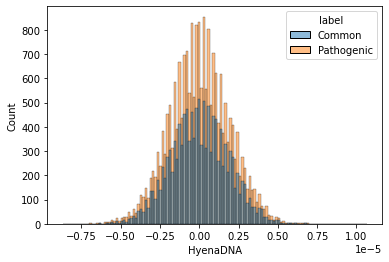

In [26]:
sns.histplot(data=V_clinvar, x="HyenaDNA", hue="label")

In [19]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 13117'

In [20]:
def clinvar_barplot(df, metric, save_path=None):
    plt.figure(figsize=(3.0,3.0))
    sns.barplot(
        data=df,
        x="Model",
        y=metric,
        palette=palette,
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    ax = plt.gca()
    #ax.axhline(baseline, ls='--', color="grey")
    plt.xticks(rotation=45, ha="right")
    #limit = min(baseline, results_clinvar[metric].min()) - 0.01
    limit = baseline
    plt.gca().set_ylim(bottom=limit);
    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.3f}'.format(p.get_height()), 
                fontsize=9, color='black', ha='center', va='bottom')
    plt.xlabel("");
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

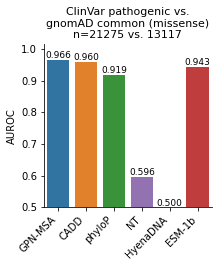

In [25]:
clinvar_barplot(
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "HyenaDNA", "ESM-1b",
    ])],
    "AUROC",
    #save_path="clinvar_auroc.svg",
)

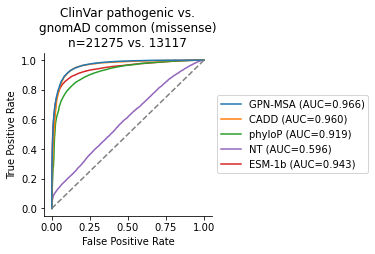

In [19]:
plot_curve(
    V_clinvar,
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
    ])],
    "ROC",
    title,
    #save_path="clinvar_roc.svg",
)

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


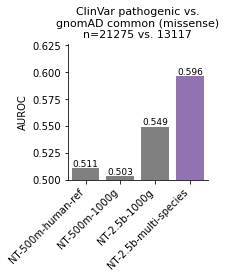

In [20]:
clinvar_barplot(
    results_clinvar[results_clinvar.Model.isin([
         "NT-500m-human-ref", "NT-500m-1000g", "NT-2.5b-1000g", "NT",
    ])].replace("NT", "NT-2.5b-multi-species"),
    "AUROC",
    #save_path="clinvar_auroc_NT.pdf",
)

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


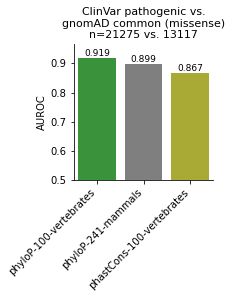

In [21]:
clinvar_barplot(
    results_clinvar[results_clinvar.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUROC",
    #save_path="clinvar_auroc_conservation.svg"
)

### Stratifying by conservation

In [25]:
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar["conservation"] = "neutral"
V_clinvar.loc[V_clinvar.phyloP < -log_pval_thresh, "conservation"] = "conserved"
V_clinvar.loc[V_clinvar.phyloP > log_pval_thresh, "conservation"] = "accelerated"
V_clinvar.conservation.value_counts()

conservation
conserved      24369
neutral         8633
accelerated     1390
Name: count, dtype: int64

In [27]:
rows = []
for c in V_clinvar.conservation.unique():
    V_c = V_clinvar[V_clinvar.conservation==c]
    for m in dataset_models["ClinVar"]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_clinvar_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC
0,neutral,GPN-MSA,0.916170,0.780884
1,neutral,CADD,0.895336,0.714260
2,neutral,phyloP,0.663319,0.254761
3,neutral,phyloP-241-mammals,0.637950,0.302476
4,neutral,phastCons-100-vertebrates,0.769634,0.394395
5,neutral,NT-500m-human-ref,0.499749,0.151674
6,neutral,NT-500m-1000g,0.481755,0.145583
7,neutral,NT-2.5b-1000g,0.526618,0.159958
8,neutral,NT,0.572771,0.202702
9,neutral,ESM-1b,0.882713,0.764948


In [63]:
def get_subtitle(c):
    n_pos, n_neg = V_clinvar[V_clinvar.conservation==c].label.value_counts()[["Pathogenic", "Common"]].values
    return f"{c} (n={n_pos} vs. {n_neg})"

results_clinvar_strat["subtitle"] = results_clinvar_strat.Conservation.apply(get_subtitle)
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,neutral,GPN-MSA,0.916170,0.780884,neutral (n=1371 vs. 7262)
1,neutral,CADD,0.895336,0.714260,neutral (n=1371 vs. 7262)
2,neutral,phyloP,0.663319,0.254761,neutral (n=1371 vs. 7262)
3,neutral,phyloP-241-mammals,0.637950,0.302476,neutral (n=1371 vs. 7262)
4,neutral,phastCons-100-vertebrates,0.769634,0.394395,neutral (n=1371 vs. 7262)
5,neutral,NT-500m-human-ref,0.499749,0.151674,neutral (n=1371 vs. 7262)
6,neutral,NT-500m-1000g,0.481755,0.145583,neutral (n=1371 vs. 7262)
7,neutral,NT-2.5b-1000g,0.526618,0.159958,neutral (n=1371 vs. 7262)
8,neutral,NT,0.572771,0.202702,neutral (n=1371 vs. 7262)
9,neutral,ESM-1b,0.882713,0.764948,neutral (n=1371 vs. 7262)


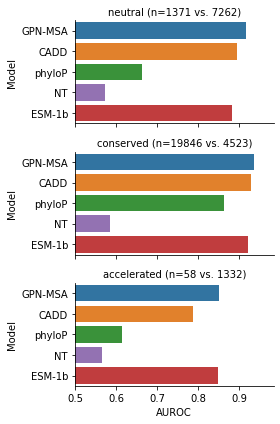

In [66]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

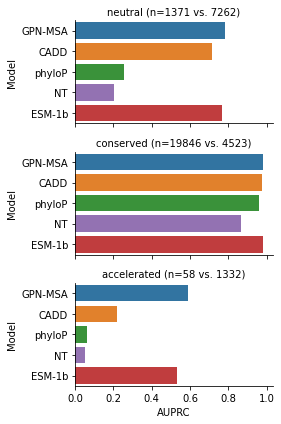

In [69]:
g = sns.catplot(
    data=results_clinvar_strat[
        results_clinvar_strat.Model.isin([
            "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
        ])
    ],
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

## COSMIC frequent vs. gnomAD common (missense)

In [18]:
V_cosmic = V[
    (V.source == "COSMIC") |
    (
        (V.label == "Common") &
        V.consequence.str.contains("missense")
    )
].copy()
V_cosmic.dropna(subset=dataset_models["COSMIC"], inplace=True)
V_cosmic.label.value_counts()

label
Common      13118
Frequent      189
Name: count, dtype: int64

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

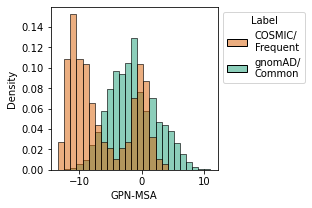

In [19]:
histplot_label(
    V_cosmic,
    hue_order=["COSMIC/\nFrequent", "gnomAD/\nCommon"],
    #save_path="hist_cosmic.svg",
)

In [20]:
rows = []
for m in dataset_models["COSMIC"]:
    AUROC = roc_auc_score(V_cosmic.label=="Frequent", -V_cosmic[m])
    AUPRC = average_precision_score(V_cosmic.label=="Frequent", -V_cosmic[m])
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"])
results_cosmic

,Model,AUROC,AUPRC
0,GPN-MSA,0.758927,0.348005
1,CADD,0.741100,0.167109
2,phyloP,0.673146,0.140805
3,phyloP-241-mammals,0.661631,0.092066
4,phastCons-100-vertebrates,0.656829,0.032115
5,ESM-1b,0.778973,0.227965


In [21]:
n_pos, n_neg = (V_cosmic.label=="Frequent").sum(), (V_cosmic.label=="Common").sum()
title = f"COSMIC frequent vs. \ngnomAD common (missense) \n n = {n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
title

'COSMIC frequent vs. \ngnomAD common (missense) \n n = 189 vs. 13118'

In [22]:
def cosmic_barplot(df, metric, save_path=None):
    plt.figure(figsize=(2.0,2.5))
    sns.barplot(
        data=df,
        x="Model",
        y=metric,
        palette=palette
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    ax = plt.gca()
    #ax.axhline(baseline, ls='--', color="grey")
    plt.xticks(rotation=45, ha="right")
    #limit = min(baseline, results_clinvar[metric].min()) - 0.01
    limit = baseline
    plt.gca().set_ylim(bottom=limit);
    
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.3f}'.format(p.get_height()), 
                fontsize=9, color='black', ha='center', va='bottom')
    plt.xlabel("");
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


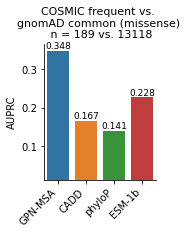

In [23]:
cosmic_barplot(
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "AUPRC",
    #save_path="cosmic_auprc.svg",
)

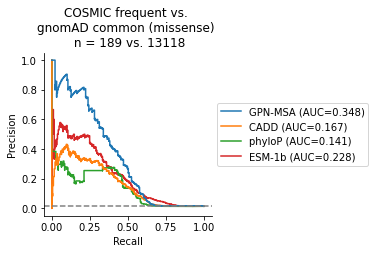

In [28]:
plot_curve(
    V_cosmic,
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "PR",
    title,
    pos_label="Frequent",
    pos_prop=pos_prop,
    save_path="cosmic_pr_curve.svg",
)

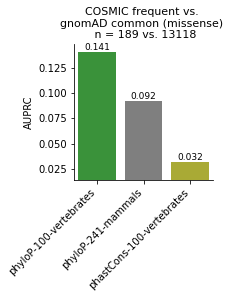

In [30]:
cosmic_barplot(
    results_cosmic[results_cosmic.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUPRC",
    #save_path="cosmic_auprc_conservation.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [24]:
omim_variant_type_dict = {
    "5_prime_UTR_variant": "5' UTR",
    "upstream_gene_variant": "Promoter",
    "intergenic_variant": "Enhancer",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}
cs = list(omim_variant_type_dict.keys())
cs

['5_prime_UTR_variant',
 'upstream_gene_variant',
 'intergenic_variant',
 '3_prime_UTR_variant',
 'non_coding_transcript_exon_variant']

In [25]:
V_omim = V[
    (V.source == "OMIM") |
    (
        (V.label == "Common") &
        np.any([V.consequence.str.contains(c) for c in cs], axis=0) &
        ~V.consequence.str.contains("missense")
    )
].copy()
V_omim.label.value_counts()

label
Common        2321067
Pathogenic        406
Name: count, dtype: int64

In [26]:
V_omim.loc[V_omim.source=="OMIM", "consequence"] = V_omim[V_omim.source=="OMIM"].consequence.str.split(" ").str[:-1].str.join(sep=" ").str.replace("’", "'").replace("RNA Gene", "ncRNA")

In [27]:
for x, y in omim_variant_type_dict.items():
    V_omim[y] = False
    V_omim.loc[(V_omim.source=="OMIM") & (V_omim.consequence==y), y] = True
    V_omim.loc[(V_omim.source!="OMIM") & (V_omim.consequence.str.contains(x)), y] = True

In [39]:
def get_subtitle(c, n_pathogenic, n_common):
    return f"{c}\nn={n_pathogenic} vs. {n_common}"

pos_prop = []

consequence_models = dataset_models["OMIM"]

rows = []
for c in consequence_models:
    V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
    V_c.dropna(subset=consequence_models[c], inplace=True)
    
    if c == "all":
        V_omim_all = V_c
    
    n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
    subtitle = get_subtitle(c, n_pos, n_neg)
    pos_prop.append(n_pos/(n_pos+n_neg))
    
    for m in consequence_models[c]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([m, c, AUROC, AUPRC, subtitle])
results_omim = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC", "AUPRC", "subtitle"])
results_omim

,Model,Consequence,AUROC,AUPRC,subtitle
0,GPN-MSA,all,0.927967,0.116074,all\nn=406 vs. 2284702
1,CADD,all,0.936614,0.032636,all\nn=406 vs. 2284702
2,phyloP,all,0.869517,0.038891,all\nn=406 vs. 2284702
3,phyloP-241-mammals,all,0.881639,0.028575,all\nn=406 vs. 2284702
4,phastCons-100-vertebrates,all,0.835147,0.005967,all\nn=406 vs. 2284702
5,GPN-MSA,Promoter,0.934313,0.044342,Promoter\nn=130 vs. 820082
6,CADD,Promoter,0.926675,0.014447,Promoter\nn=130 vs. 820082
7,phyloP,Promoter,0.881289,0.011281,Promoter\nn=130 vs. 820082
8,phyloP-241-mammals,Promoter,0.897380,0.021060,Promoter\nn=130 vs. 820082
9,phastCons-100-vertebrates,Promoter,0.859121,0.005709,Promoter\nn=130 vs. 820082


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

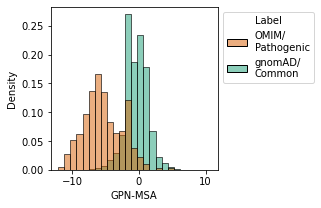

In [55]:
histplot_label(
    V_omim_all,
    hue_order=["OMIM/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_omim.svg",
)

In [34]:
replacements = {"Promoter": "promoter", "Enhancer": "enhancer"}

for key, value in replacements.items():
    results_omim['subtitle'] = results_omim['subtitle'].str.replace(key, value)

In [35]:
def omim_plot(
    df,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    g = sns.catplot(
        data=df,
        x="Model",
        y="AUPRC",
        col="subtitle",
        height=2,
        aspect=0.9,
        kind="bar",
        col_wrap=3,
        sharey=False,
        sharex=True,
        legend=False,
        palette=palette,
    )
    #g.set_xticklabels(rotation=45, ha="right")
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    for i, ax in enumerate(g.axes):
        ax.set_ylim(bottom=pos_prop[i])
        ax.set_xlabel("")
    g.fig.suptitle(title, y=y, fontsize=12, x=x)

    for ax in g.axes.flat:
        for p in ax.patches:
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:.3f}'.format(p.get_height()),
                    fontsize=9, color='black', ha='center', va='bottom')
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

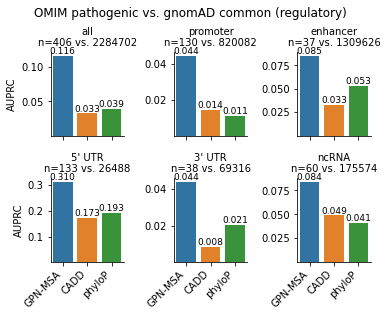

In [36]:
omim_plot(
    results_omim[results_omim.Model.isin([
        "GPN-MSA", "CADD", "phyloP",
    ])],
    #save_path="omim_auprc.svg",
)

In [37]:
title = "OMIM pathogenic vs.\ngnomAD common (regulatory)" + "\n" + results_omim[results_omim.Consequence=="all"].subtitle.iloc[0]

In [38]:
def omim_curve_plot(
    subset_models,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
        pos_prop = n_pos/(n_pos+n_neg)
        subtitle = get_subtitle(c, n_pos, n_neg)

        for m in np.array(consequence_models[c])[::-1]:
            if m not in subset_models: continue
            AUC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
            plot_f.from_predictions(V_c.label==pos_label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels)#, loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

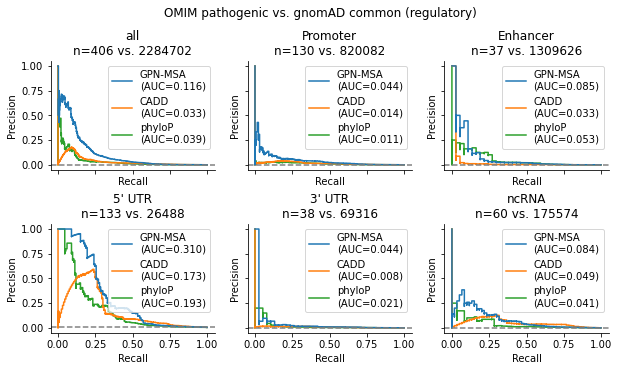

In [39]:
omim_curve_plot(
    subset_models=["GPN-MSA", "CADD", "phyloP"],
    save_path="omim_pr_curves.svg",
)

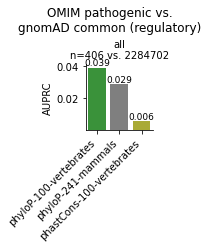

In [57]:
omim_plot(
    results_omim[(results_omim.Consequence=="all") & results_omim.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    title="OMIM pathogenic vs.\ngnomAD common (regulatory)",
    x=0.2, y=1.15,
    #save_path="omim_auprc_conservation.svg",
)

## gnomAD rare vs. common

In [9]:
V_gnomad = V[V.source == "gnomAD"].copy()
V_gnomad.label.value_counts()

label
Rare      4869209
Common    4869209
Name: count, dtype: int64

In [10]:
# Drop 32 variants with MAF 1/n but AF > 0.5
# In the case of GPN-MSA and other LLR-based methods, it would be easy
# to include these variants in the analysis by "folding" (considering the major as the reference)
# (flipping the scores when AF > 0.5)
# but CADD and phyloP are only computed assuming a fixed ref
V_gnomad = V_gnomad[V_gnomad.AC != V_gnomad.AN - 1].copy()
V_gnomad.label.value_counts()

label
Common    4869209
Rare      4869177
Name: count, dtype: int64

In [11]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    if threshold == df[model_name].max():  # happens with SpliceAI
        print("WARNING: threshold == max(score)", threshold_quantile, model_name)
        return None, None, None, None, None, None
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    odds_ratio, p_value, min_counts, ci_lower, ci_upper = _compute_odds_ratio(df)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper, threshold

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    #if np.isinf(odds_ratio):
    #    print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [39]:
np.logspace(-2, 0, 11)

array([0.01      , 0.01584893, 0.02511886, 0.03981072, 0.06309573,
       0.1       , 0.15848932, 0.25118864, 0.39810717, 0.63095734,
       1.        ])

In [40]:
#threshold_quantiles = np.logspace(-5, -1, 21)
threshold_quantiles = np.logspace(-2, 0, 11)[:-1]

consequence_models = dataset_models["gnomAD"]

rows = []
for c in list(consequence_models.keys()):
    if c != "missense": continue
    print(c)
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence.str.contains(c)]
        # optional filter
        if c != "missense": df_c = df_c[~df_c.consequence.str.contains("missense")]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    
    if c == "all":
        #df_c.to_parquet("subset_4_gnomad_vs_gnomad.parquet", index=False)
        #print(len(df_c))
        V_gnomad_all = df_c
        #raise Exception("debug")
    # optional subsample
    #df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42).sample(frac=1, random_state=42)
    
    for m in tqdm(consequence_models[c]):
        subtitle = get_subtitle(c, (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
        for tq in threshold_quantiles:
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, threshold, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Consequence", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold", "subtitle"])
results_gnomad

missense


  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_2801289/558961428.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low"
/tmp/ipykernel_2801289/558961428.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df.groupby(["label", "ModelScoreTier"]).size()
/tmp/ipykernel_2801289/558961428.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[model_name] <= threshold, "ModelScoreTier"]

,Model,Consequence,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold,subtitle
0,GPN-MSA,missense,0.010000,89.259221,8.023525e-63,2,21.636875,368.223623,-11.902051,missense\nn=37757 vs. 13118
1,GPN-MSA,missense,0.015849,71.240881,9.163442e-98,4,26.137555,194.175129,-11.614945,missense\nn=37757 vs. 13118
2,GPN-MSA,missense,0.025119,50.656901,2.614711e-150,9,25.938777,98.929940,-11.268719,missense\nn=37757 vs. 13118
3,GPN-MSA,missense,0.039811,52.685187,3.828571e-240,14,30.801601,90.116383,-10.867368,missense\nn=37757 vs. 13118
4,GPN-MSA,missense,0.063096,34.330667,0.000000e+00,35,24.422391,48.258776,-10.336395,missense\nn=37757 vs. 13118
5,GPN-MSA,missense,0.100000,25.576976,0.000000e+00,78,20.339064,32.163805,-9.679398,missense\nn=37757 vs. 13118
6,GPN-MSA,missense,0.158489,20.764826,0.000000e+00,165,17.717302,24.336549,-8.831086,missense\nn=37757 vs. 13118
7,GPN-MSA,missense,0.251189,13.715728,0.000000e+00,448,12.427637,15.137326,-7.750453,missense\nn=37757 vs. 13118
8,GPN-MSA,missense,0.398107,9.650130,0.000000e+00,1247,9.060967,10.277601,-6.213605,missense\nn=37757 vs. 13118
9,GPN-MSA,missense,0.630957,7.818555,0.000000e+00,3677,7.469918,8.183464,-3.867370,missense\nn=37757 vs. 13118


/tmp/ipykernel_2801289/2596275445.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["Label"] = V.source + "/\n" + V.label
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaf

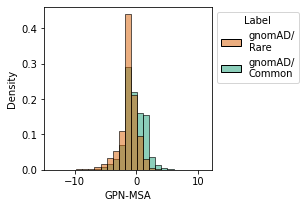

In [ ]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

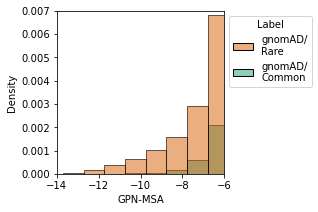

In [116]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

In [41]:
print("Careful if inf, should handle separately: ", results_gnomad["Odds ratio"].max())

Careful if inf, should handle separately:  89.25922147651006


In [42]:
limit_per_consequence = results_gnomad.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
missense    0.025119
Name: Quantile threshold, dtype: float64

In [43]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_gnomad["above_limit"] = results_gnomad.apply(above_limit, axis=1)

In [44]:
results_gnomad[results_gnomad.above_limit].min_counts.min()

14

In [45]:
results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min()

0.039810717055349734

In [24]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}

for key, value in replacements.items():
    results_gnomad['subtitle'] = results_gnomad['subtitle'].str.replace(key, value)
    results_gnomad['Consequence'] = results_gnomad['Consequence'].str.replace(key, value)

In [35]:
x = results_gnomad.subtitle.drop_duplicates()
x = "``" + results_gnomad.Consequence.drop_duplicates() + "'': " + x.str.split('\n').str[-1].str.replace("n=", "$n=$ ")
x = ", ".join(x.values)
x

"``all'': $n=$ 4812825 vs. 4811795, ``missense'': $n=$ 37757 vs. 13118, ``synonymous'': $n=$ 18647 vs. 17566, ``5' UTR'': $n=$ 35538 vs. 26488, ``3' UTR'': $n=$ 82954 vs. 69316, ``upstream-of-gene'': $n=$ 849851 vs. 820082, ``downstream-of-gene'': $n=$ 869964 vs. 852410, ``intron'': $n=$ 1804469 vs. 1690417, ``intergenic'': $n=$ 1226643 vs. 1309626, ``ncRNA'': $n=$ 183960 vs. 175574"

In [79]:
def gnomad_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        col="subtitle",
        #col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=min(5, len(df.subtitle.unique())),
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

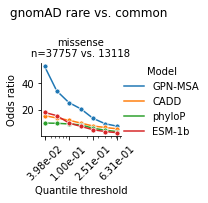

In [81]:
import warnings
warnings.filterwarnings('ignore')
gnomad_plot(
    results_gnomad[results_gnomad.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b", "SpliceAI",
    ])],
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

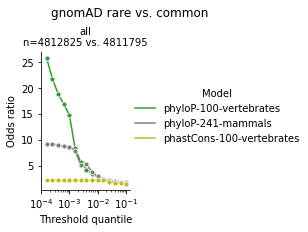

In [90]:
gnomad_plot(
    results_gnomad[(results_gnomad.Consequence=="all") & results_gnomad.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    y=1.25, height=2.5,
    #save_path="gnomad_or_conservation.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
V_enformer = V_enformer[V_enformer.AF < 0.95]
V_enformer["label"] = "Common"
V_enformer.loc[V_enformer.AF < 0.05, "label"] = "Rare"  # for convenience, actually low-frequency
V_enformer.label.value_counts()

/tmp/ipykernel_2751701/1964085982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V_enformer["label"] = "Common"


label
Rare      3589128
Common    2149352
Name: count, dtype: int64

In [17]:
threshold_quantiles = np.logspace(-5, -1, 21)
enformer_models = [
    "GPN-MSA", "CADD", "phyloP", "Enformer_l1", "Enformer_l2", "Enformer_linf",
    "phyloP-241-mammals", "phastCons-100-vertebrates",
]

rows = []

df_c = V_enformer.dropna(subset=enformer_models)

for m in tqdm(enformer_models):
    for tq in threshold_quantiles:
        OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
        rows.append([m, tq, OR, p_value, min_counts, cil, ciu, threshold])
results_enformer = pd.DataFrame(rows, columns=["Model", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold"])
results_enformer

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_2751701/558961428.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low"
/tmp/ipykernel_2751701/558961428.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df.groupby(["label", "ModelScoreTier"]).size()
/tmp/ipykernel_2751701/558961428.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[model_name] <= threshold, "ModelScoreTier"]

,Model,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold
0,GPN-MSA,0.000010,3.677863,8.540318e-05,8,1.715460,7.885159,-10.055309
1,GPN-MSA,0.000016,4.312479,8.121926e-08,11,2.265676,8.208357,-9.696720
2,GPN-MSA,0.000025,3.692931,4.078663e-10,20,2.280088,5.981236,-9.345236
3,GPN-MSA,0.000040,2.879235,2.343502e-11,39,2.024755,4.094320,-9.064564
4,GPN-MSA,0.000063,2.515100,5.602958e-14,69,1.923852,3.288053,-8.742804
...,...,...,...,...,...,...,...,...
163,phastCons-100-vertebrates,0.015849,1.210156,1.075581e-160,29854,1.193006,1.227553,-0.987000
164,phastCons-100-vertebrates,0.025119,1.189070,3.701030e-208,47928,1.175648,1.202645,-0.855000
165,phastCons-100-vertebrates,0.039811,1.182180,8.899071e-303,76306,1.171500,1.192957,-0.554000
166,phastCons-100-vertebrates,0.063096,1.180551,0.000000e+00,121413,1.171981,1.189183,-0.324000


In [32]:
n_pos, n_neg = (df_c.label=="Rare").sum(), (df_c.label=="Common").sum()
title = f"gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)"  #\nn={n_pos} vs. {n_neg}"
title

'gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)'

In [19]:
limit = results_enformer.query("min_counts < 10")["Quantile threshold"].max()
limit

9.999999999999999e-06

In [20]:
def above_limit(r):
    return np.isnan(limit) or r["Quantile threshold"] > limit + 1e-8

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [29]:
def enformer_plot(df, save_path=None):
    plt.figure(figsize=(2,2))
    g = sns.lineplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        marker="o",
        palette=palette,
        markersize=5,
    )
    #for ax in g.axes: ax.axhline(1, ls='--', color="grey")
    #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=0.75)
    #plt.suptitle("gnomAD rare vs. common", y=0.9);
    sns.despine()
    #ax.set_ylim(bottom=pos_prop[i])
    plt.ylim(bottom=1)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    #g.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax = g     
    xticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_xticks(xticks)

    secax = ax.secondary_xaxis('top')
    secax.set_xscale('log')
    secax.set_xticks(xticks)
    subset_df = df[(df['Model'] == "GPN-MSA")]
    tick_labels = [
        subset_df[
            np.isclose(subset_df["Quantile threshold"], tq)
        ].Threshold.values[0]
        for tq in xticks
    ]
    tick_labels = [f"{x:.1f}" for x in tick_labels]
    secax.set_xticklabels(tick_labels)
    secax.set_xlabel("GPN-MSA score")

    plt.title(title, fontsize=11);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

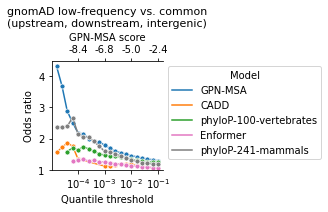

In [34]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "Enformer_l2", "phyloP-241-mammals",
    ])].replace({"Enformer_l2": "Enformer", "phyloP": "phyloP-100-vertebrates"}),
    #save_path="gnomad_or_enformer.svg",
)

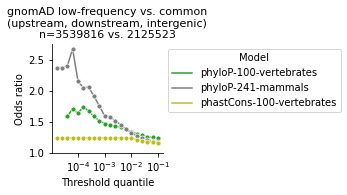

In [110]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    #save_path="gnomad_or_enformer_conservation.svg",
)

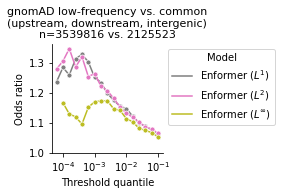

In [112]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "Enformer_l1", "Enformer_l2", "Enformer_linf",
    ])].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    #save_path="gnomad_or_enformer_norms.pdf",
)